# Solar Panel Defect Classification

This project focuses on classifying solar panel defects using the VGG16 convolutional neural network architecture. The goal is to categorize solar panel images into six classes: Clean, Dusty, Bird-drop, Electrical-damage, Physical-Damage, and Snow-Covered.

We'll be using transfer learning with the VGG16 model pre-trained on ImageNet to improve accuracy and reduce training time.

In [1]:
#Importing all the required modules

from tensorflow.keras.regularizers import l2
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from collections import Counter
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

Mounting my google drive in my google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip my dataset file

In [3]:
!unzip /content/drive/My\ Drive/Faulty_solar_panel.zip -d /content/

Archive:  /content/drive/My Drive/Faulty_solar_panel.zip
   creating: /content/Faulty_solar_panel/
  inflating: /content/__MACOSX/._Faulty_solar_panel  
  inflating: /content/Faulty_solar_panel/.DS_Store  
  inflating: /content/__MACOSX/Faulty_solar_panel/._.DS_Store  
   creating: /content/Faulty_solar_panel/Physical-Damage/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Physical-Damage  
   creating: /content/Faulty_solar_panel/Dusty/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Dusty  
   creating: /content/Faulty_solar_panel/Snow-Covered/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Snow-Covered  
   creating: /content/Faulty_solar_panel/Clean/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Clean  
   creating: /content/Faulty_solar_panel/Electrical-damage/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Electrical-damage  
   creating: /content/Faulty_solar_panel/Bird-drop/
  inflating: /content/__MACOSX/Faulty_solar_panel/._Bird-drop  
  inflating: /co

## Data Loading and Preprocessing

The dataset consists of solar panel images categorized into six different classes. We'll first load the dataset and then apply basic data augmentation to improve the model's generalization.

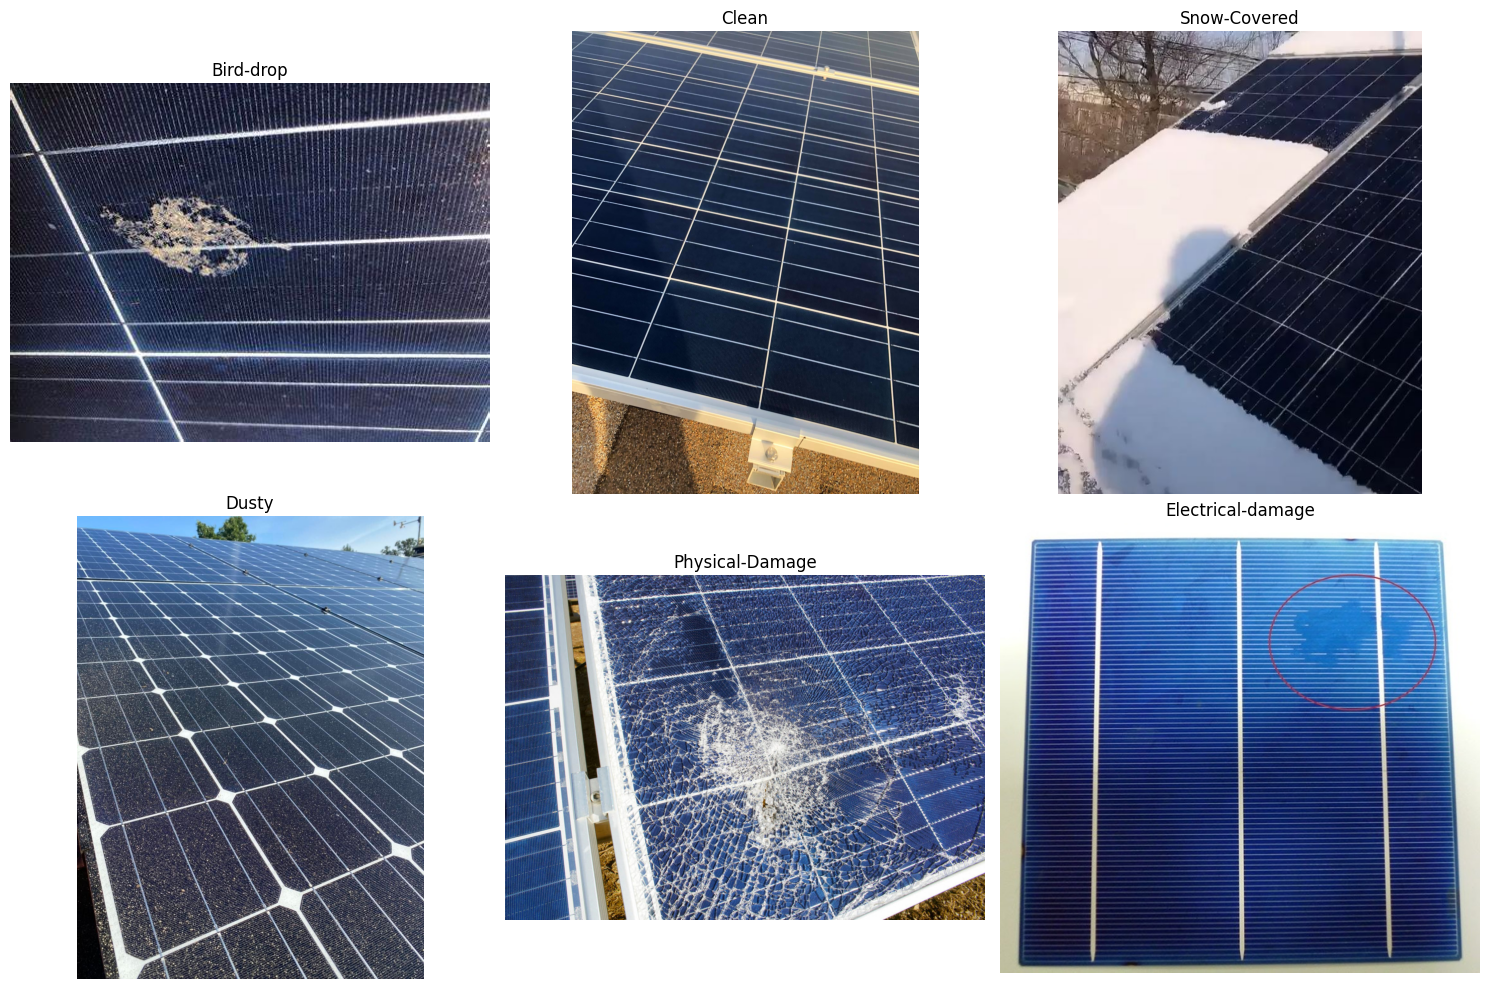

In [4]:

# Define the dataset
dataset_dir = '/content/Faulty_solar_panel'

# Checking the directory
assert os.path.exists(dataset_dir), "The dataset directory path is incorrect."

# classes in the dataset
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Filter out non-image files
valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')

# Display one image from each class
plt.figure(figsize=(15, 10))

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_dir, cls)

    #files in the class directory and filter out non-image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(valid_extensions)]

    # Check if there are any valid image files in the directory
    if len(image_files) > 0:
        # display the first image in the directory
        sample_image = Image.open(os.path.join(class_path, image_files[0]))
        plt.subplot(2, 3, i + 1)
        plt.imshow(sample_image)
        plt.title(cls)
        plt.axis('off')
    else:
        print(f"No valid images found in {cls}")

plt.tight_layout()
plt.show()

### Data Augmentation

To improve the model's performance and make it more robust to different scenarios, we apply several augmentations like rotation, zoom, width/height shifting, and horizontal flipping.   
We use the `ImageDataGenerator` class from Keras to apply real-time data augmentation during training. This includes:
- Rescaling the pixel values,
- Randomly rotating the images,
- Zooming, shifting,adjusting brightness and flipping the images to make the model more robust.

In [5]:
# Initialize the ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.1],
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)




# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


##Generating synthetic data
Generating synthetic images for 20 % of the dataset, we want to generate images for each class and print how many synthetic images were generated for each class.

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from PIL import Image

# Define the dataset directory and the directory for synthetic images
dataset_dir = '/content/Faulty_solar_panel'
synthetic_dir = '/content/synthetic_data/'
if not os.path.exists(synthetic_dir):
    os.makedirs(synthetic_dir)

# Function to generate synthetic images using augmentation
def generate_synthetic_images(image, augmentor, n_augmented=5):
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, 0)

    augmented_images = []
    for _ in range(n_augmented):
        for batch in augmentor.flow(img_array, batch_size=1):
            augmented_images.append(array_to_img(batch[0]))
            if len(augmented_images) >= n_augmented:
                break
    return augmented_images

# Initialize the ImageDataGenerator with augmentation
augmentor = ImageDataGenerator(rotation_range=30, zoom_range=0.2, horizontal_flip=True)

# Loop through each class and generate synthetic images
for class_name in train_generator.class_indices.keys():
    class_image_files = [f for f in train_generator.filenames if f.startswith(class_name)]
    num_class_images = len(class_image_files)
    num_synthetic_per_class = int(0.2 * num_class_images)

    print(f"Processing class {class_name}: {num_class_images} real images, generating {num_synthetic_per_class} synthetic images.")

    # Initialize a counter to track the number of synthetic images saved
    synthetic_image_counter = 0

    # Process each image in the class
    for img_file in class_image_files:
        if synthetic_image_counter >= num_synthetic_per_class:
            break

        img_path = os.path.join(dataset_dir, img_file)
        try:
            sample_image = Image.open(img_path)

            # Generate synthetic images
            synthetic_images = generate_synthetic_images(sample_image, augmentor, n_augmented=5)

            # Create a folder for synthetic images by class
            class_synthetic_dir = os.path.join(synthetic_dir, class_name)
            if not os.path.exists(class_synthetic_dir):
                os.makedirs(class_synthetic_dir)

            # Save synthetic images to disk
            for idx, img in enumerate(synthetic_images):
                img.save(os.path.join(class_synthetic_dir, f'{class_name}_synthetic_{synthetic_image_counter}_{idx}.png'))
                synthetic_image_counter += 1

                # Stop if we have reached the required number of synthetic images for this class
                if synthetic_image_counter >= num_synthetic_per_class:
                    break

        except Exception as e:
            print(f"Error processing image {img_file}: {e}")

Processing class Bird-drop: 166 real images, generating 33 synthetic images.
Processing class Clean: 155 real images, generating 31 synthetic images.
Processing class Dusty: 152 real images, generating 30 synthetic images.
Processing class Electrical-damage: 83 real images, generating 16 synthetic images.
Processing class Physical-Damage: 56 real images, generating 11 synthetic images.
Processing class Snow-Covered: 99 real images, generating 19 synthetic images.


In [7]:
# Check how many synthetic images were generated for each class
for class_name in train_generator.class_indices.keys():
    class_synthetic_dir = os.path.join(synthetic_dir, class_name)
    if os.path.exists(class_synthetic_dir):
        print(f"{class_name}: {len(os.listdir(class_synthetic_dir))} synthetic images")
    else:
        print(f"No synthetic images found for {class_name}")

Bird-drop: 33 synthetic images
Clean: 31 synthetic images
Dusty: 30 synthetic images
Electrical-damage: 16 synthetic images
Physical-Damage: 11 synthetic images
Snow-Covered: 19 synthetic images


After generating synthetic images, we are combining them with real data for training

In [8]:
# Combine original and synthetic datasets
combined_dir = '/content/combined_dataset/'

if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# Copy original images to the combined directory
os.system(f'cp -r {dataset_dir}/* {combined_dir}')

# Copy synthetic images to the combined directory
os.system(f'cp -r {synthetic_dir}/* {combined_dir}')

# Update the train_generator to use the combined dataset
train_generator = train_datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 822 images belonging to 6 classes.
Found 203 images belonging to 6 classes.


Inspecting the validation data

In [9]:
# Check the total number of images in the training and validation sets
print(f"Number of images in the training set: {train_generator.samples}")
print(f"Number of images in the validation set: {validation_generator.samples}")

Number of images in the training set: 822
Number of images in the validation set: 203


##Class Distribution in Training Set

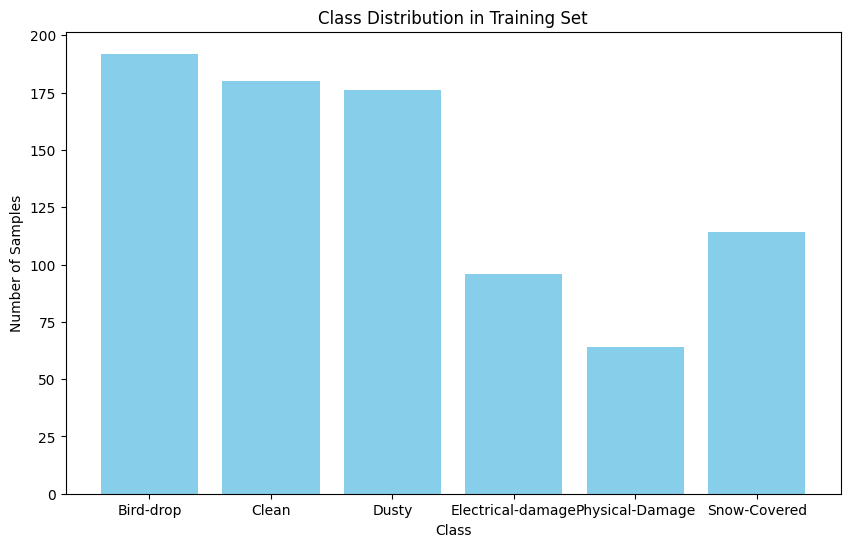

In [10]:
# Get class counts for the training set
train_class_counts = Counter(train_generator.classes)
classes = list(train_generator.class_indices.keys())

# Plot class distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(classes, list(train_class_counts.values()), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.show()

##Class Distribution in Validation Set

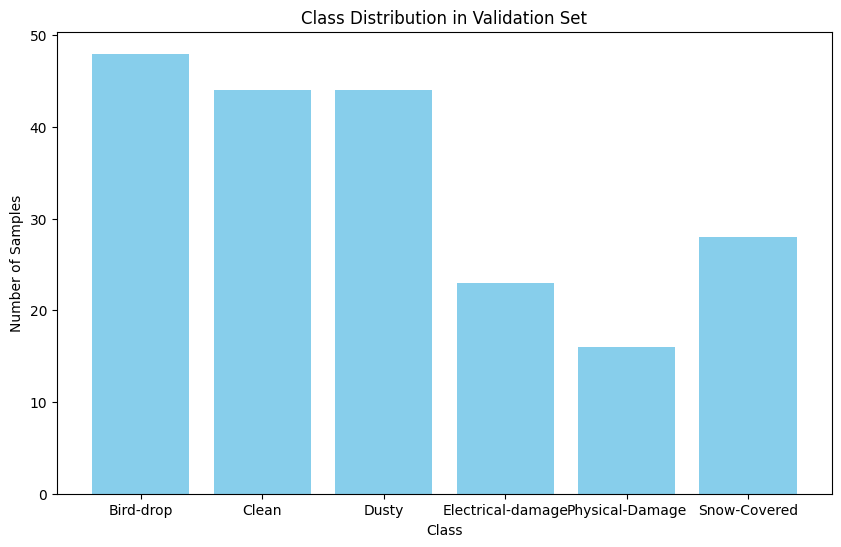

In [11]:
# Get class counts for the validation set
val_class_counts = Counter(validation_generator.classes)

# Plot class distribution for the validation set
plt.figure(figsize=(10, 6))
plt.bar(classes, list(val_class_counts.values()), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')
plt.show()

##visualising some synthetic data generated

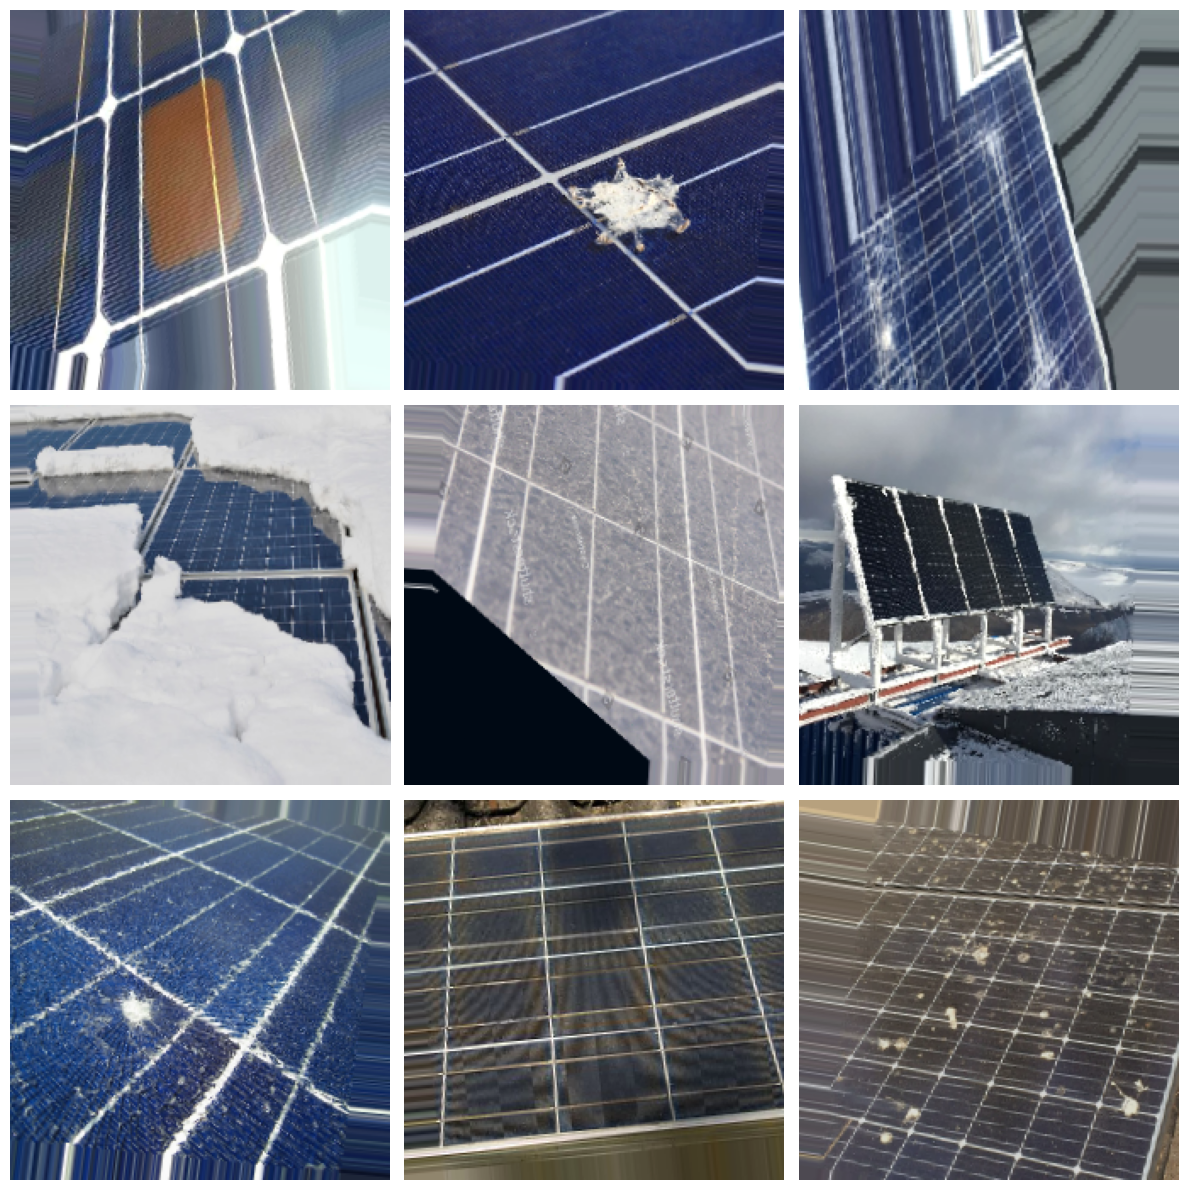

In [12]:
# Display some random images from the training set
batch = next(train_generator)  # Get a batch of images and labels
images, labels = batch

plt.figure(figsize=(12, 12))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Checking if the classes are are balanced in our dataset and apply some class weights to give more importance to the minority classes

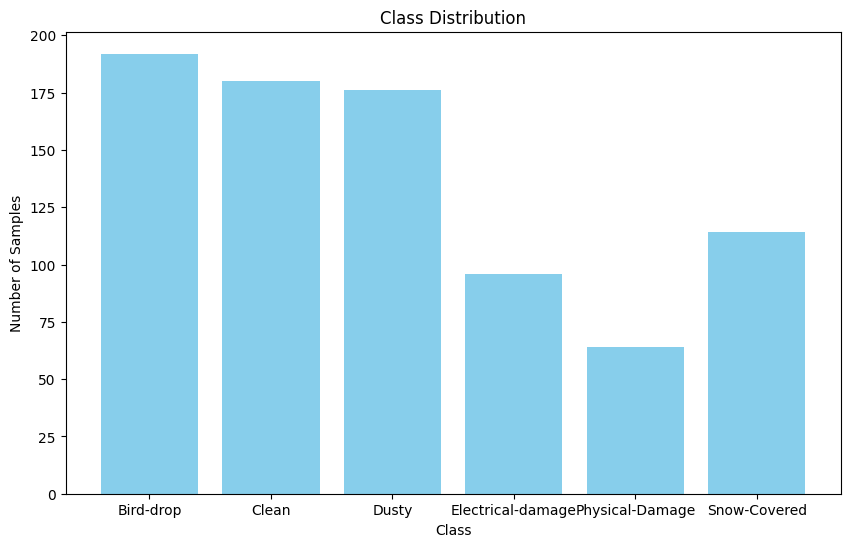

Class Weights: {0: 0.7135416666666666, 1: 0.7611111111111111, 2: 0.7784090909090909, 3: 1.4270833333333333, 4: 2.140625, 5: 1.2017543859649122}


In [13]:
# Get class counts
class_counts = Counter(train_generator.classes)
classes = list(train_generator.class_indices.keys())

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, list(class_counts.values()), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

# Calculate class weights because the dataset is imbalanced
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

## Model Architecture

We are using the VGG16 model pre-trained on ImageNet for transfer learning. The convolutional layers are frozen initially, and custom dense layers are added on top to fine-tune the model for our specific task of classifying solar panel defects.

In [14]:
# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Test the Model on a Smaller Subset

To quickly evaluate the model’s performance without using the entire dataset, we train the model on a smaller subset (30%) of the data. This approach allows us to test the model’s training behavior and identify any issues before full-scale training.

In [32]:
# Test on a smaller subset (e.g., 30%)
subset_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
# Calculate the number of steps per epoch based on the size of the subset and batch size
steps_per_epoch_subset = subset_generator.samples // subset_generator.batch_size
validation_steps_subset = validation_generator.samples // validation_generator.batch_size

# Train on the subset to evaluate performance
history_subset = model.fit(
    subset_generator,
    validation_data=validation_generator,
    epochs=5,  # Use fewer epochs for testing
    steps_per_epoch= steps_per_epoch_subset,
    validation_steps= validation_steps_subset
)

Found 711 images belonging to 6 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7977 - loss: 0.6744 - val_accuracy: 0.7812 - val_loss: 0.6103
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.5145 - val_accuracy: 0.6364 - val_loss: 0.6810
Epoch 3/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 961ms/step - accuracy: 0.7592 - loss: 0.6647 - val_accuracy: 0.8125 - val_loss: 0.5399
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8750 - loss: 0.5268 - val_accuracy: 0.9091 - val_loss: 0.2115
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 937ms/step - accuracy: 0.8119 - loss: 0.5748 - val_accuracy: 0.8333 - val_loss: 0.5149


## Early Stopping
 Early Stopping helps avoid overfitting and unnecessary training time, which leads to better generalization of the model on unseen data.

In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Model Training

The model is trained with a combination of early stopping and learning rate reduction to optimize performance while avoiding overfitting. We use class weights to address any class imbalance in the dataset.

In [34]:
# Train on the full dataset
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size


history_full = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Full training epochs
    steps_per_epoch= steps_per_epoch,
    validation_steps= validation_steps,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 993ms/step - accuracy: 0.8146 - loss: 0.5479 - val_accuracy: 0.8177 - val_loss: 0.5420
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4136 - val_accuracy: 0.7273 - val_loss: 0.6813
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 953ms/step - accuracy: 0.8301 - loss: 0.4874 - val_accuracy: 0.8073 - val_loss: 0.5590
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8125 - loss: 0.4336 - val_accuracy: 0.7273 - val_loss: 0.5558


## Model Evaluation

We evaluate the model's performance using accuracy, loss plots, and a confusion matrix. The confusion matrix provides insight into how well the model is classifying each class.

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.8184 - loss: 0.5166
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step


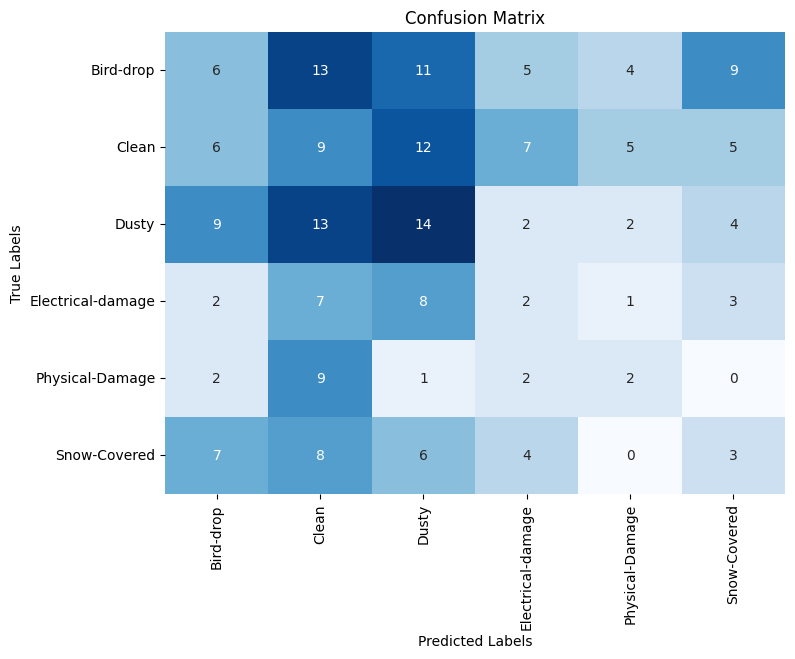

In [35]:

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)

# Generate predictions
y_pred = model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, y_pred_classes)

# Plotting a colorful confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions for the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion Matrix for detailed insights
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step
Classification Report:
                    precision    recall  f1-score   support

        Bird-drop       0.34      0.23      0.28        48
            Clean       0.34      0.45      0.39        44
            Dusty       0.29      0.34      0.31        44
Electrical-damage       0.09      0.09      0.09        23
  Physical-Damage       0.07      0.06      0.07        16
     Snow-Covered       0.17      0.14      0.15        28

         accuracy                           0.26       203
        macro avg       0.22      0.22      0.21       203
     weighted avg       0.26      0.26      0.25       203

Confusion Matrix:
 [[11 13 14  7  1  2]
 [ 4 20  9  6  2  3]
 [ 7  7 15  3  6  6]
 [ 4  7  4  2  2  4]
 [ 0  3  4  3  1  5]
 [ 6  9  6  1  2  4]]


In [ ]:
# Save your model
model.save('solar_panel_model_full.h5')

## Visualizing Model Predictions
This visual approach helps in understanding how well the model is performing on individual examples.This visual approach helps in understanding how well the model is performing on individual examples.

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step


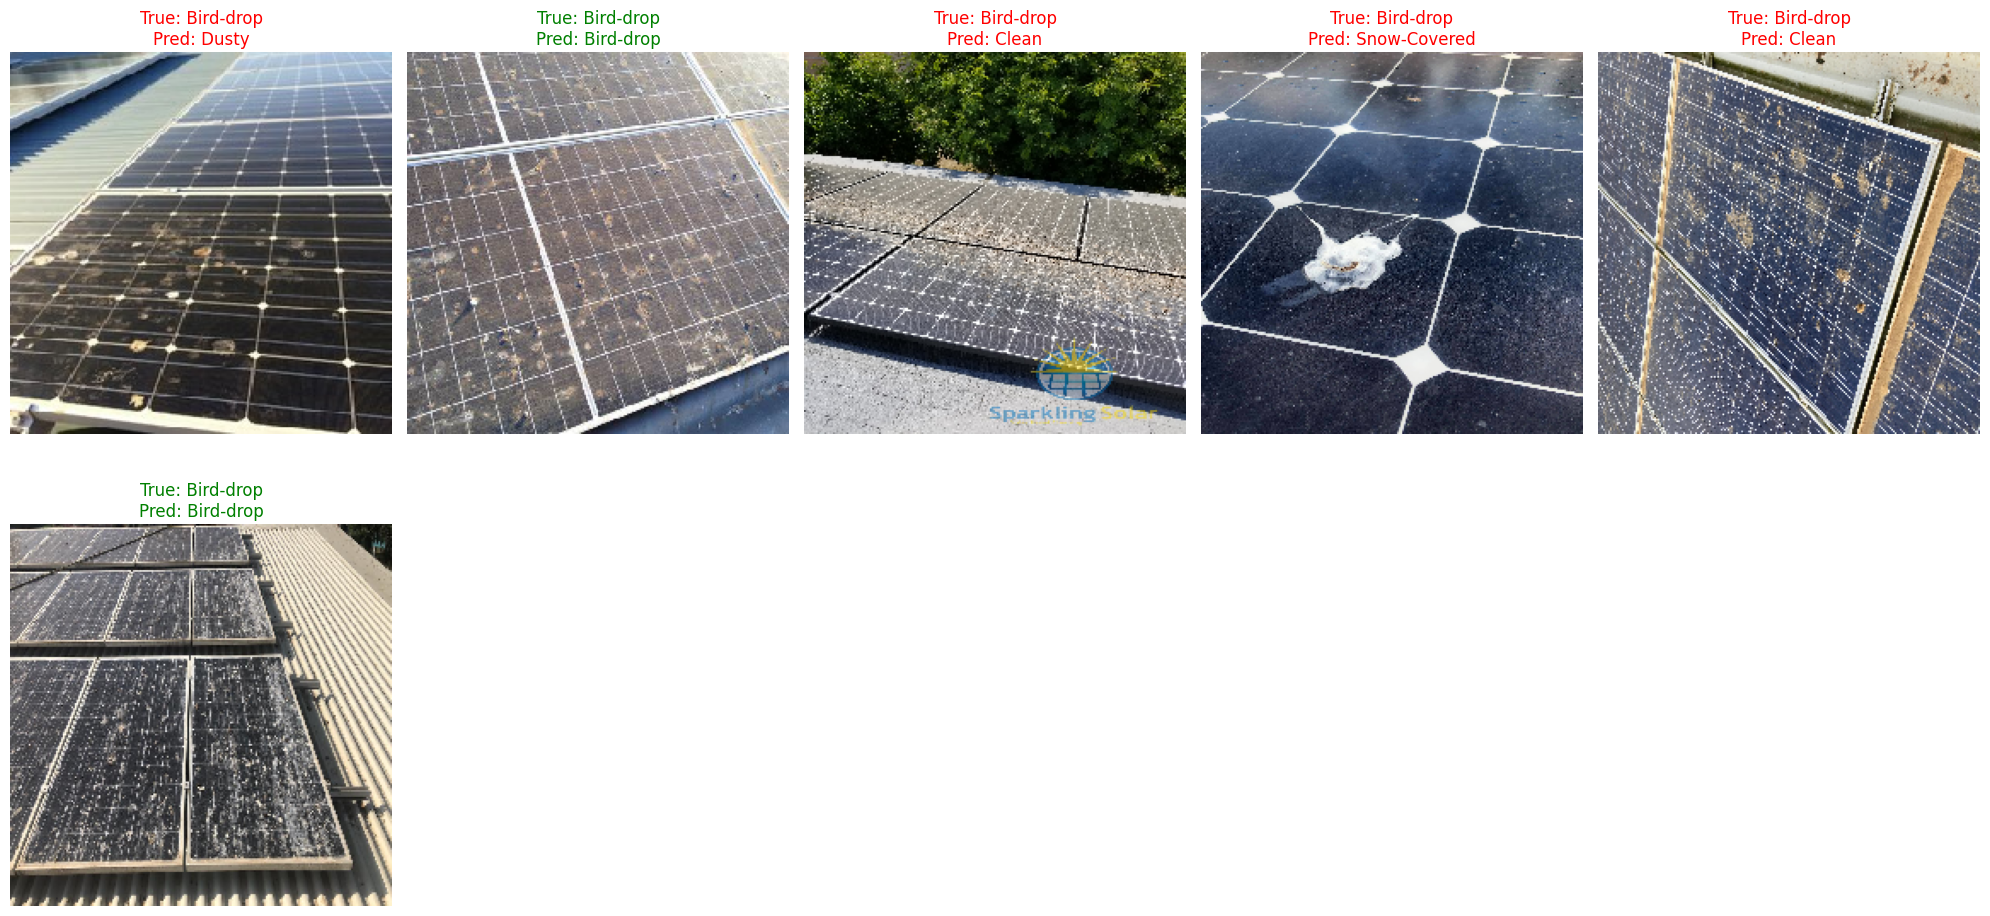

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Disable shuffle in the validation generator if it was enabled
validation_generator.shuffle = False

# Reset the generator to start from the beginning
validation_generator.reset()

# Generate predictions for the entire validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted classes
y_true = validation_generator.classes  # True labels

# Function to display images with their predicted and true labels
def display_predictions(validation_generator, y_pred_classes, y_true, class_labels, num_images=10):
    # Reset the validation generator to ensure consistency in indexing
    validation_generator.reset()

    # Initialize the counter for number of images displayed
    image_count = 0

    # Plot images with predicted and true labels
    plt.figure(figsize=(20, 10))

    # Iterate over the batches in the generator
    for batch in validation_generator:
        img_batch, label_batch = batch  # Get images and labels in the batch

        for i in range(len(img_batch)):
            if image_count >= num_images:
                break

            # Display the image and predictions
            plt.subplot(2, 5, image_count + 1)
            plt.imshow(img_batch[i])
            true_label = class_labels[y_true[image_count]]
            predicted_label = class_labels[y_pred_classes[image_count]]
            color = 'green' if true_label == predicted_label else 'red'
            plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color)
            plt.axis('off')
            image_count += 1

        if image_count >= num_images:
            break  # Stop the outer loop once the required number of images is displayed

    plt.tight_layout()
    plt.show()

# Display images with predicted and true labels
display_predictions(validation_generator, y_pred_classes, y_true, class_labels, num_images=6)